# Setup

In [ ]:
!pip install -qU langchain
!pip install -qU langchain-google-genai
!pip install -qU langchain-huggingface
!pip install -qU langchain-qdrant
!pip install -qU langchain-community
!pip install -qU langgraph
!pip install fastembed
!pip install datasets
# !pip install -U "fsspec[http]==2024.10.0"

# Code

In this assignment, you will need to set up and use
1. LangSmith to monitor your agent.
2. Use hybrid search to improve your retriever
3. Use a reranker to improve your search result.



## TODO 0: Set up LangSmith

Create a LangSmith account and set up tracing for this assignment. https://www.smith.langchain.com/.

No need to configure, just add your LangSmith API key.

In [ ]:
import os
from google.colab import userdata

os.environ["GOOGLE_API_KEY"] = userdata.get('gemini_api_key')

## Components

We will be using Gemini as our LLM. Feel free to try out others if you want.

In [ ]:
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash-001")

For our sentence embeddings, we will use [ModernBERT](https://arxiv.org/abs/2412.13663) trained by Alibaba as it is small and performant.

In [ ]:
from langchain_huggingface import HuggingFaceEmbeddings

model_kwargs = {'trust_remote_code': True}
embeddings = HuggingFaceEmbeddings(model_name="Alibaba-NLP/gte-modernbert-base",model_kwargs=model_kwargs)

Likewise, the reranker is also based on the ModernBERT trained by Alibaba.

In [ ]:
from langchain.retrievers import ContextualCompressionRetriever
from langchain.retrievers.document_compressors import CrossEncoderReranker
from langchain_community.cross_encoders import HuggingFaceCrossEncoder

model = HuggingFaceCrossEncoder(model_name="Alibaba-NLP/gte-reranker-modernbert-base")

For our dataset, we will be using SQuAD v2 dataset.

In [ ]:
import datasets

ds = datasets.load_dataset("rajpurkar/squad_v2", split="validation")

## Indexing

In [ ]:
from langchain_core.documents import Document

In [ ]:
all_docs = [Document(text) for text in  list(set(ds["context"]))]
print(len(all_docs))

In [ ]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=2000,  # chunk size (characters)
    chunk_overlap=200,  # chunk overlap (characters)
    add_start_index=True,  # track index in original document
)
all_splits = text_splitter.split_documents(all_docs)

print(f"Split wiki abstract into {len(all_splits)} sub-documents.")

## TODO 1: Hybrid Search
Embed your documents in a vector database that supports hybrid search. Also set the retrieval mode to hybrid search. Use BM25 as the lexical search.

Hint: read more on `QdrantVectorStore` [here](https://python.langchain.com/api_reference/qdrant/qdrant/langchain_qdrant.qdrant.QdrantVectorStore.html#langchain_qdrant.qdrant.QdrantVectorStore). (You can use any vector DB that can do hybrid search)

## TODO 2: Reranking

Create two retrievers.
1. A normal retriever without a reranker. Set the `top_k` to 20.
2. A retriever with a reranker. Set the `top_k` of the reranker to 3.


Take a subset of the dataset to evaluate the MRR of the retrievers.

In [ ]:
sample = ds.take(1000)

## TODO 3: Retrieval Evaluation

Calculate the MRR of the two retrievers based on the top 3 returned by each retriever.

**For the vanilla retriever (no reranker), take only the top-3 to evaluate the MRR and ignore the rest.**

In [ ]:
print(f"MRR of the retriever without a reranker: {no_rerank / len(sample):.4f}")
print(f"MRR of the retriever with a reranker: {rerank / len(sample):.4f}")

print(f"Percentage of queries with no relevant doc in top 3 (no rerank): {100 * no_rerank_failures / len(sample):.2f}%")
print(f"Percentage of queries with no relevant doc in top 3 (rerank): {100 * rerank_failures / len(sample):.2f}%")

## Agentic RAG

Feel free to use the workflow from the demo. However, you will need to modify it slightly to use the retriever with a reranker.

## TODO 4: Usage
Run your agent twice. Once on a message that doesn't need tool-use like "hello" and again for a message that does.

## TODO 5: Monitor your agent in LangSmith.

If you have set up correctly, you can just visit the LangSmith website and see that your tracings are logged into your LangSmith project.

Capture your screen like this and upload it to MCV.

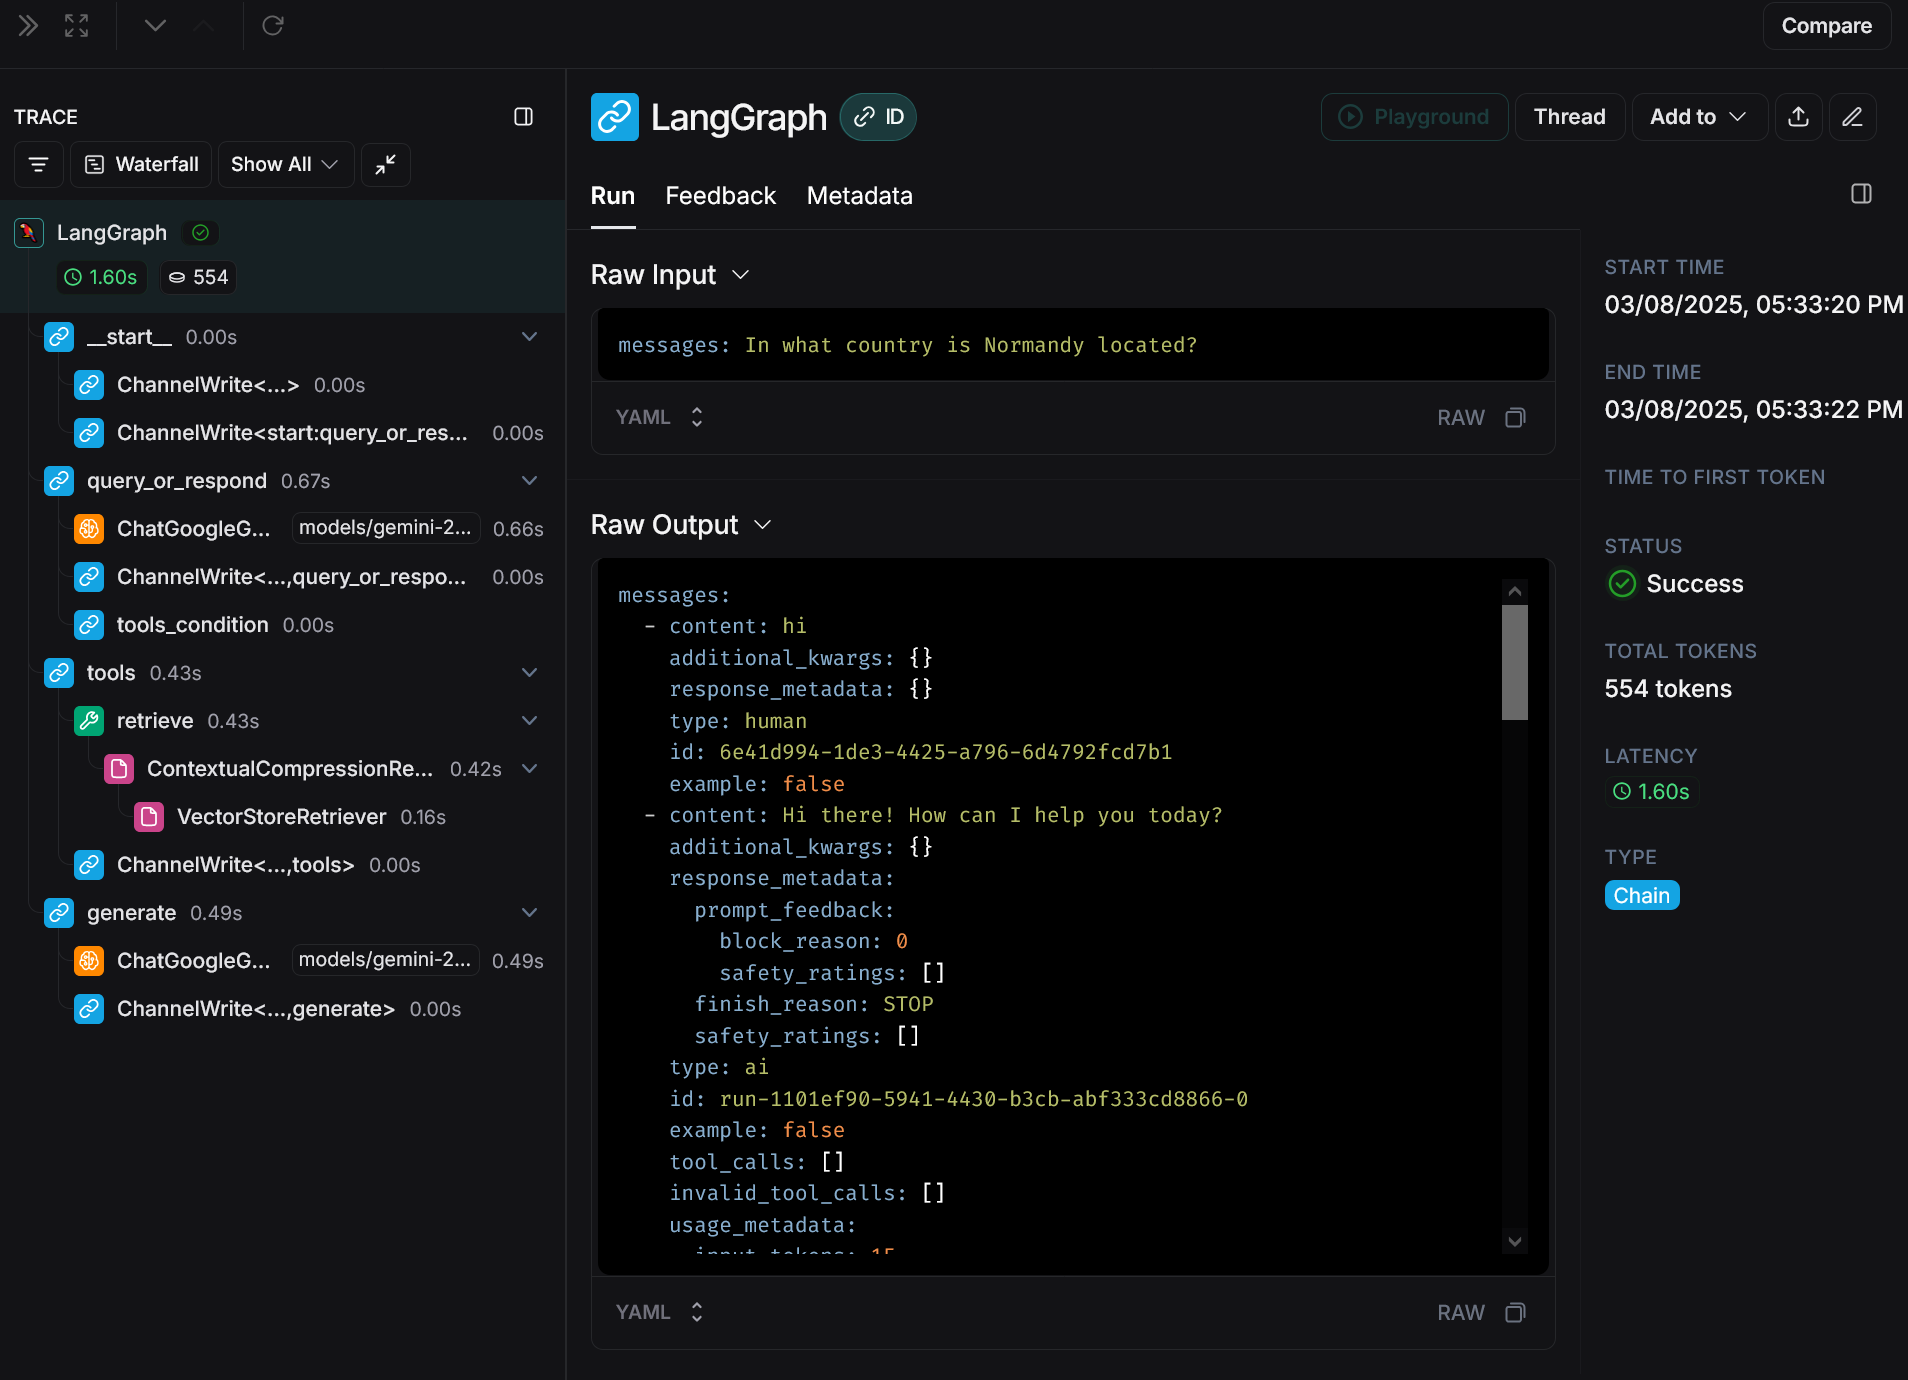